In [1]:
import torch
import torch.nn as nn
from models import Flow, FlowKernel
from train_dynamics import load_model
from distributions import vf_lorenz
import matplotlib.pyplot as plt
from test_chaotic import get_stable_trajectory, load_lorenz

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# font size to 10
matplotlib.rcParams['font.size'] = 10

# Uniqueness Experiments

Load pre-trained model:

In [2]:
score_model, dataset = load_model('lorenz')
score_model.eval()
score_model.double()

Diffusion(
  (nonlinear): ReLU()
  (mlp): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
  (alpha): Embedding(100, 1)
)

Choose 1024 states to compute representation of dynamics:

In [ ]:
# Randomly sample 64 points from the time series
indices = torch.randperm(len(dataset.time_series))[:1024]
x = dataset.time_series[indices].double()

t = 0.2
alpha_t = score_model.alpha_t(torch.tensor(t))
x = alpha_t.sqrt() * x

## Compute dynamics representations

### Lorenz System (Ground truth)

In [43]:
v_lorenz = vf_lorenz(sigma=10.0, rho=28.0, beta=8.0/3.0)
dynamics_lorenz = []

for x_point in x:
    xt = dataset.denormalize(x_point)
    with torch.no_grad():
        delta = v_lorenz(xt) / dataset.std
    dynamics_lorenz.append(delta.reshape(-1))

dynamics_lorenz = torch.cat(dynamics_lorenz)
dynamics_lorenz = dynamics_lorenz.reshape(1, -1) / (dynamics_lorenz.norm() + 1e-9)

### Score Function

In [31]:
dynamics_score = []

with torch.no_grad():
    dynamics_score = score_model.eps_predictor(x, torch.ones(len(x), 1) * 0.2).reshape(-1)

dynamics_score = dynamics_score.reshape(1, -1) / (dynamics_score.norm() + 1e-9)

### Learned Model

In [ ]:
dynamics = []

def load_dynamics_model(id):
    v = FlowKernel(dim=dataset.dim)
    v.load_state_dict(torch.load(f'./results/lorenz/models/dynamics_model_{id}.pth'))
    v.eval().double()
    return v

for id in range(100):
    v = load_dynamics_model(id)
    xt = x
    with torch.no_grad():
        delta = v(xt).reshape(-1)
    dynamics.append(delta) # [batch, 3 * samples]

dynamics = torch.stack(dynamics)
dynamics = dynamics / dynamics.norm(dim=-1).mean()

### Training-free Method

In [ ]:
dynamics_D = []

def v_flow(s_fn, D):
    def v(x):
        return torch.einsum('ij, bj -> bi', D, s_fn(x))
    return v

def random_train_free_dynamics(score, dim=3):
    D = torch.randn(dim, dim).double()
    D = D - D.t()
    D = D / D.norm()
    return v_flow(score.score, D)

for id in range(100):
    v = random_train_free_dynamics(score_model, 3)
    xt = x
    with torch.no_grad():
        delta = v(xt).reshape(-1)
    dynamics_D.append(delta) # [batch, 3 * samples]

dynamics_D = torch.stack(dynamics_D)
dynamics_D = dynamics_D / dynamics_D.norm(dim=-1).mean()

### Training-free Method (high $\tau$)

In [138]:
dynamics_D_H = []

def v_flow(s_fn, D):
    def v(x):
        return torch.einsum('ij, bj -> bi', D, s_fn(x))
    return v

for id in range(100):
    d1 = torch.randn(3, 3).double()
    D = d1 - d1.t(); D = D / D.norm()
    v = v_flow(lambda x:score_model.score(x, t=0.25), D)
    xt = x
    with torch.no_grad():
        delta = v(xt).reshape(-1)
    dynamics_D_H.append(delta) # [batch, 3 * samples]

dynamics_D_H = torch.stack(dynamics_D_H)
dynamics_D_H = dynamics_D_H / dynamics_D_H.norm(dim=-1).mean()

### Random Dynamics

In [41]:
dynamics_random = []

for id in range(100):
    v = FlowKernel(dim=dataset.dim)
    v.eval().double()
    xt = x
    with torch.no_grad():
        delta = v(xt).reshape(-1)
    dynamics_random.append(delta) # [batch, 3]

dynamics_random = torch.stack(dynamics_random)
dynamics_random = dynamics_random / dynamics_random.norm(dim=-1).mean()

# Analysis

In [ ]:
# Align direction of dynamics
def direction_align(v, ref):
    sign = torch.einsum('nd, xd -> n', v, ref).sign()
    return v * sign.unsqueeze(dim=1)

In [121]:
BACKGROUND_COLOR = '#CECECE'
SUB_COLOR = '#9BE1E1'
HIGHLIGHT_COLOR = '#FEB400'
MAIN_COLOR = '#628FCE'

/home/yanbo/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


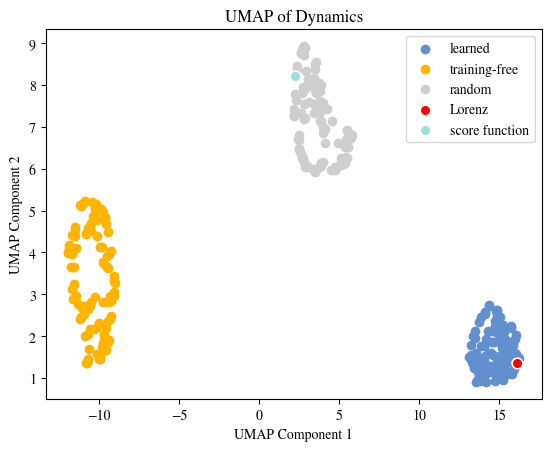

In [122]:
# Apply UMAP on dynamics
from umap import UMAP

def plot_embedding(dynamics, dynamics_D, dynamics_random, dynamics_lorenz, dynamics_score, ax=None, alpha=1, dimx=0, dimy=1, n_components=2):
    if ax is None:
        ax = plt.gca()

    dynamics = direction_align(dynamics, dynamics_lorenz)
    dynamics_D = direction_align(dynamics_D, dynamics_lorenz)
    dynamics_random = direction_align(dynamics_random, dynamics_lorenz)
    dynamics_score = direction_align(dynamics_score, dynamics_lorenz)
    umap = UMAP(n_components=n_components, random_state=0, metric='cosine', n_neighbors=15)
    all_data = torch.cat([
            dynamics, 
            dynamics_D,
            dynamics_random, 
            dynamics_lorenz,
            dynamics_score
        ], dim=0).numpy()
    
    embeddings = umap.fit_transform(all_data)
    
    n_dynamics = len(dynamics)
    n_dynamics_D = len(dynamics_D)
    n_random = len(dynamics_random)
    
    dynamics_umap = embeddings[:n_dynamics]
    dynamics_D_umap = embeddings[n_dynamics:n_dynamics+n_dynamics_D]
    random_umap = embeddings[n_dynamics+n_dynamics_D:n_dynamics+n_dynamics_D+n_random]
    emb_lorenz = embeddings[n_dynamics+n_dynamics_D+n_random:]
    emb_score = embeddings[n_dynamics+n_dynamics_D+n_random+1:]

    ax.scatter(dynamics_umap[:, dimx], dynamics_umap[:, dimy], color=MAIN_COLOR, label=r'learned', alpha=alpha)
    ax.scatter(dynamics_D_umap[:, dimx], dynamics_D_umap[:, dimy], color=HIGHLIGHT_COLOR, label=r'training-free', alpha=alpha)
    ax.scatter(random_umap[:, dimx], random_umap[:, dimy], color=BACKGROUND_COLOR, label=f'random', alpha=alpha)
    ax.scatter(emb_lorenz[:, dimx], emb_lorenz[:, dimy], color='white', marker='o', s=60)
    ax.scatter(emb_lorenz[:, dimx], emb_lorenz[:, dimy], color='red', marker='o', label=f'Lorenz', s=30)
    ax.scatter(emb_score[:, dimx], emb_score[:, dimy], color='white', marker='o', s=60)
    ax.scatter(emb_score[:, dimx], emb_score[:, dimy], color=SUB_COLOR, marker='o', label=f'score function', s=30)
    # ax.scatter(emb_score[:, dimx], emb_score[:, dimy], color=SUB_COLOR, marker='x', label=f'score function')

plot_embedding(
    dynamics,
    dynamics_D, 
    dynamics_random, 
    dynamics_lorenz,
    dynamics_score,
    n_components=2,
    dimx=0, dimy=1
    )
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP of Dynamics')
plt.legend()
plt.show()

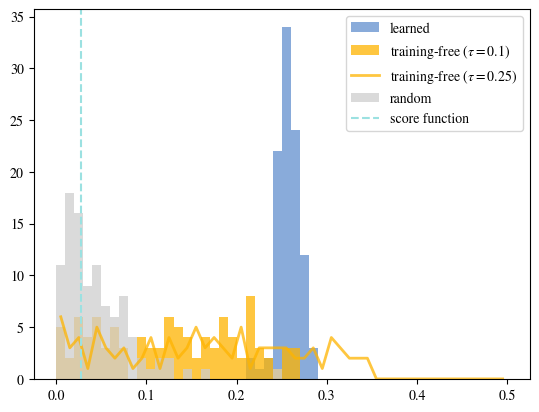

In [149]:
def plot_similarity(dynamics, dynamics_D, dynamics_random, dynamics_lorenz, dynamics_score, ax=None, dynamics_D_H=None, alpha=0.75):
    dynamics = dynamics / dynamics.norm(dim=-1, keepdim=True)
    dynamics_D = dynamics_D / dynamics_D.norm(dim=-1, keepdim=True)
    dynamics_random = dynamics_random / dynamics_random.norm(dim=-1, keepdim=True)
    dynamics_lorenz = dynamics_lorenz / dynamics_lorenz.norm(dim=-1, keepdim=True)
    dynamics_score = dynamics_score / dynamics_score.norm(dim=-1, keepdim=True)

    sim_score = torch.einsum('od, od->o', dynamics_score, dynamics_lorenz).abs().item()

    if ax is None:
        ax = plt.gca()
    ax.hist(
        torch.einsum('nd, xd->n', dynamics, dynamics_lorenz).abs().numpy(), 
        density=True,
        label='learned',
        color=MAIN_COLOR,
        alpha=alpha,
        bins=50, range=(0, 0.5))
    ax.hist(
        torch.einsum('nd, xd->n', dynamics_D, dynamics_lorenz).abs().numpy(), 
        density=True,
        label=r'training-free ($\tau=0.1$)',
        color=HIGHLIGHT_COLOR,
        alpha=alpha,
        bins=50, range=(0, 0.5))
    
    if dynamics_D_H is not None:
        ax.hist(
            torch.einsum('nd, xd->n', dynamics_D_H, dynamics_lorenz).abs().numpy(), 
            density=True,
            label=r'training-free ($\tau=0.25$)',
            color=HIGHLIGHT_COLOR,
            alpha=alpha,
            bins=50, range=(0, 0.5))
    ax.hist(
        torch.einsum('nd, xd->n', dynamics_random, dynamics_lorenz).abs().numpy(), 
        density=True,
        label='random',
        color=BACKGROUND_COLOR,
        alpha=alpha,
        bins=50, range=(0, 0.5))

    # add vertical line
    ax.axvline(sim_score, color=SUB_COLOR, linestyle='--', label='score function')

plot_similarity(dynamics, dynamics_D, dynamics_random, dynamics_lorenz, dynamics_score, dynamics_D_H=dynamics_D_H)
plt.legend()
plt.show()

/home/yanbo/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


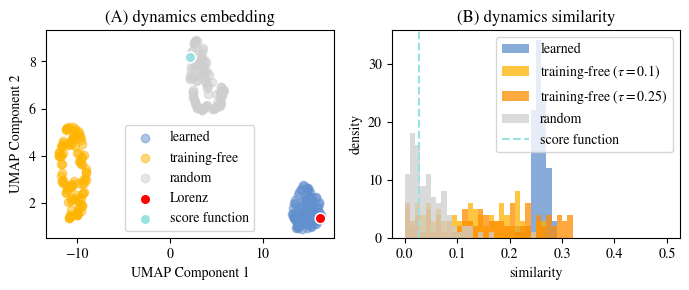

In [148]:
plt.figure(figsize=(7, 3))
plt.subplot(1,2,1)
plot_embedding(dynamics, dynamics_D, dynamics_random, dynamics_lorenz, dynamics_score, alpha=0.5)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('(A) dynamics embedding')
# plt.legend(loc='upper left')
plt.legend()

plt.subplot(1,2,2)
plot_similarity(dynamics, dynamics_D, dynamics_random, dynamics_lorenz, dynamics_score, dynamics_D_H=dynamics_D_H)
plt.xlabel('similarity')
plt.ylabel('density')
plt.title('(B) dynamics similarity')
plt.legend()

plt.tight_layout()
plt.savefig('./results/lorenz/uniqueness.pdf', bbox_inches='tight')
plt.show()

# Distribution Preservation Measure

Using MMD to test if the distribution is been preserved

In [26]:
import importlib
import utils
importlib.reload(utils)

from utils import integrate_rk4, mmd2_rbf_unbiased

In [7]:
score_model, dataset = load_model('lorenz')
score_model.eval()
score_model.double()
v = load_dynamics_model(0)

In [43]:
v = random_train_free_dynamics(score_model, 3)

In [49]:
v = FlowKernel(dim=dataset.dim).double()

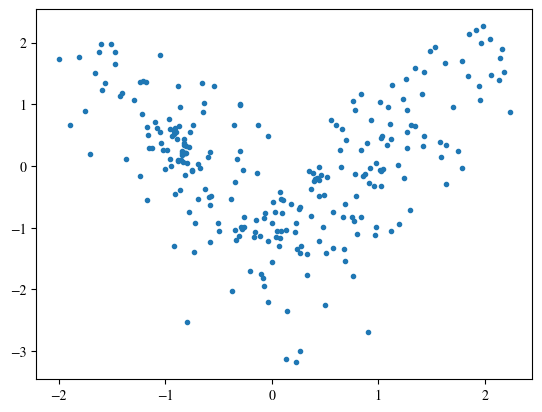

In [14]:
num_samples = 256
indices = torch.randperm(len(dataset.time_series))[:num_samples]
x0 = dataset.time_series[indices].double()

plt.plot(x0[:,0], x0[:,2], '.')
plt.show()

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

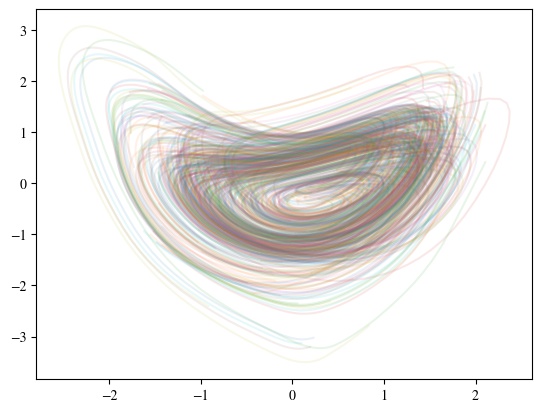

In [110]:
from tqdm.notebook import tqdm

models = {
    'learned': [load_dynamics_model(i) for i in range(64)],
    'training-free': [random_train_free_dynamics(score_model, 3) for _ in range(64)],
    'random': [FlowKernel(dim=dataset.dim).double() for _ in range(64)],
    'score': [score_model.score],
}

results = {}

for model_name, models in models.items():
    all_traj = []
    for model in tqdm(models):
        x = x0
        traj = []
        for i in range(100):
            with torch.no_grad():
                x = integrate_rk4(model, x, 0.1)
            traj.append(x)
        traj = torch.stack(traj)
        all_traj.append(traj)
    results[model_name] = torch.stack(all_traj)

for i in range(num_samples):
    plt.plot(results['learned'][0, :, i, 0], results['learned'][0, :, i, 2], '-', alpha=0.1)
plt.show()

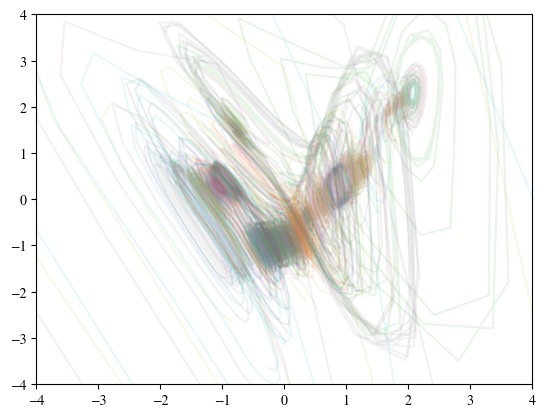

In [132]:
for i in range(num_samples):
    plt.plot(results['training-free'][4, :, i, 0], results['training-free'][4, :, i, 2], '-', alpha=0.1)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

In [112]:
mmd_results = {}
for model_name, trajs in results.items():
    mmd = []
    for traj in trajs:
        mmd.append(torch.vmap(mmd2_rbf_unbiased, in_dims=(None, 0, None))(x0, traj, 0.5))
    mmd_results[model_name] = torch.stack(mmd)

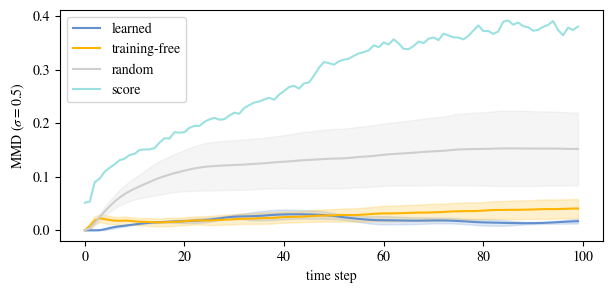

In [125]:
BACKGROUND_COLOR = '#CECECE'
SUB_COLOR = '#9BE1E1'
HIGHLIGHT_COLOR = '#FEB400'
MAIN_COLOR = '#628FCE'


def plot_with_error_shadow(data, label, color=None, **kwargs):
    mean_vals = data.mean(dim=0).numpy()
    std_vals = data.std(dim=0).numpy()
    x_vals = range(len(mean_vals))
    
    plt.plot(x_vals, mean_vals, label=label, color=color, **kwargs)
    plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, alpha=0.2, color=color)

plt.figure(figsize=(7, 3))
plot_with_error_shadow(mmd_results['learned'], 'learned', color=MAIN_COLOR)
plot_with_error_shadow(mmd_results['training-free'], 'training-free', color=HIGHLIGHT_COLOR)
plot_with_error_shadow(mmd_results['random'], 'random', color=BACKGROUND_COLOR)
plot_with_error_shadow(mmd_results['score'], 'score', color=SUB_COLOR)
plt.legend()
plt.xlabel('time step')
plt.ylabel('MMD ($\sigma=0.5$)')
plt.savefig('./results/lorenz/mmd.pdf', bbox_inches='tight')
plt.show()

## Quantitative Results

In [123]:
def avg_sim(e1, e2, ref=None):
    if ref is not None:
        e1 = direction_align(e1, ref)
        e2 = direction_align(e2, ref)
    e1 = e1 / e1.norm(dim=-1, keepdim=True)
    e2 = e2 / e2.norm(dim=-1, keepdim=True)
    # compute cross similarity nd, xd -> nx
    cross_sim = torch.einsum('nd, xd->nx', e1, e2).abs()
    return cross_sim.mean().item(), cross_sim.std().item()

In [128]:
import math
import pandas as pd

all_dynamics = [dynamics, dynamics_D, dynamics_random, dynamics_lorenz, dynamics_score]
all_names = ['e_theta', 'e_D', 'e_R', 'e_L', 'e_s']

result_table = []
for name1, d1 in zip(all_names, all_dynamics):
    row = []
    for name2, d2 in zip(all_names, all_dynamics):
        row.append(avg_sim(d1, d2, ref=dynamics_lorenz))
        # print(f'<{name1}, {name2}>:', avg_sim(d1, d2, ref=dynamics_lorenz))
    result_table.append((name1, row))

# print table as markdown
# Build a DataFrame of raw mean/std first
means = {}
stds = {}
for name, row in result_table:
    means[name] = [m for (m, s) in row]
    stds[name] = [s for (m, s) in row]

df_mean = pd.DataFrame(means, index=all_names)
df_std = pd.DataFrame(stds, index=all_names)

# Combined formatted table
def fmt(m, s):
    if s != s or math.isnan(s):
        return f'{m:.6f}'
    return f'{m:.6f} ± {s:.6f}'

df_fmt = pd.DataFrame(
    [[fmt(df_mean.loc[r, c], df_std.loc[r, c]) for c in df_mean.columns] for r in df_mean.index],
    index=df_mean.index,
    columns=df_mean.columns
)

print(df_fmt.to_markdown())

|         | e_theta             | e_D                 | e_R                 | e_L                 | e_s                 |
|:--------|:--------------------|:--------------------|:--------------------|:--------------------|:--------------------|
| e_theta | 0.998771 ± 0.000500 | 0.371136 ± 0.199189 | 0.071135 ± 0.050895 | 0.256986 ± 0.012326 | 0.005353 ± 0.002022 |
| e_D     | 0.371136 ± 0.199189 | 0.504188 ± 0.290123 | 0.116499 ± 0.078915 | 0.128612 ± 0.077212 | 0.022564 ± 0.013353 |
| e_R     | 0.071135 ± 0.050895 | 0.116499 ± 0.078915 | 0.388614 ± 0.244349 | 0.045376 ± 0.039081 | 0.083685 ± 0.057560 |
| e_L     | 0.256986 ± 0.012326 | 0.128612 ± 0.077212 | 0.045376 ± 0.039081 | 1.000000            | 0.026940            |
| e_s     | 0.005353 ± 0.002022 | 0.022564 ± 0.013353 | 0.083685 ± 0.057560 | 0.026940            | 1.000000            |
